# Introduction to AVIRIS-NG

<img alt="AVIRIS Logo" src="images/aviris-ng/Aviris.png" style="margin:auto"/>

<br><b>Contributors:</b> Joachim Meyer<sup>1</sup>, Chelsea Ackroyd<sup>1</sup>, McKenzie Skiles<sup>1</sup>, Phil Dennison<sup>1</sup>, Keely Roth<sup>1</sup>
<br>
<sup>1</sup>University of Utah


```{admonition} Learning Objectives

* Become familiar with hyperspectral data, including data orginiating from AVIRIS-NG
* Understand the fundamental methods for displaying and exploring hyperspectral data in Python
* Identify the amount of ice in a given pixel using spectral feature fitting methodology

```

## Review of Hyperspectral Data



Incoming solar radiation is either reflected, absorbed, or transmitted (or a combination of all three) depending on the surface material. This spectral response allows us to identify varying surface types (e.g. vegetation, snow, water, etc.) in a remote sensing image. The <b>spectral resolution</b>, or the wavelength interval, determines the amount of detail recorded in the spectral response: finer spectral resolutions have bands with narrow wavelength intervals, while coarser spectral resolutions have bands with larger wavelength intervals, and therefore, less detail in the spectral response.

![NEON Tutorial](https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/dev-aten/graphics/hyperspectral-general/spectrumZoomed.png)

![NEON FWHM](https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/dev-aten/graphics/hyperspectral-general/FWHM2.png)

https://www.neonscience.org/resources/learning-hub/tutorials/hyper-spec-intro

### Multispectral vs. Hyperspectral Data

Multispectral instruments have larger spectral resolutions with fewer bands. This level of detail can be limiting in distinguishing between surface types. Hyperspectral instruments, in comparison, typically have hundreds of bands with relatively narrow wavelength intervals. The image below illustrates the difference in spectral responses between a multispectral (Landsat 8 OLI) and a hyperspectral (AVIRIS) sensor.

<img alt="AVIRIS Logo" src="images/aviris-ng/Hyper_vs_Multispectral.png" style="margin:auto"/>

## Computing environment

We'll be using the following open source Python libraries in this notebook:

## SnowEx21 Spectral Reflectance Dataset

The data were collected using an airborne imaging spectrometer, AVIRIS-NG can be downloaded from here, https://nsidc.org/data/snex21_ssr/versions/1.
- Reflectance is provided at 5 nm spectral resolution with a range of 380-2500 nm

- For this dataset, the pixel resolution is 4 m

- Data span from 19 March 2021 to 29 April 2021, and were collected in two snow-covered environments in Colorado: Senator Beck Basin and Grand Mesa

- Each file will have a "__.img__" and "__.hdr__". You need to have both of these in the same directory to open data.

<p align="center">
  <img src="https://avirisng.jpl.nasa.gov/img/rmotc_large.png" />
</p>




## Accessing AVIRIS-NG Data from S3

For this tutorial, we've hosted the AVIRIS-NG data on AWS S3 for easy access. The data is streamed directly from the cloud, so **no downloads are required**!

The data is stored in a public S3 bucket in the `us-west-2` region:
- **Bucket**: `s3://snowex-tutorials/aviris-ng/`
- **Region**: us-west-2 (Oregon)

We'll use `rasterio` to read ENVI format files directly from S3. This approach:
- Works with the original ENVI format (no conversion needed)
- Streams data on-demand (only reads what you need)
- Requires no authentication for public buckets
- Enables cloud-native workflows

```{note}
If you want to use your own local AVIRIS-NG files instead, simply replace the S3 paths with local file paths.
```

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

## Loading AVIRIS-NG data with rasterio

We'll use `rasterio` to open and read the AVIRIS-NG ENVI files directly from S3.

In [8]:
# S3 paths for AVIRIS-NG data (public bucket, no auth required)
s3_bucket = "snowex-tutorials"
s3_prefix = "aviris-ng"
# ENVI format requires opening the .img data file (not .hdr)
reflectance_file = "SNEX21_SSR_ang20210429t191025_SBB_rfl_v2z1a.img"

print(f"Data source: s3://{s3_bucket}/{s3_prefix}/{reflectance_file}")
print(f"Region: us-west-2")
print(f"\nNote: This data is publicly accessible, no AWS credentials needed!")

Data source: s3://snowex-tutorials/aviris-ng/SNEX21_SSR_ang20210429t191025_SBB_rfl_v2z1a.img
Region: us-west-2

Note: This data is publicly accessible, no AWS credentials needed!


In [ ]:
# Configure rasterio to access S3 with anonymous (no-auth) access
# Set environment variables for anonymous S3 access
import os
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'
os.environ['AWS_REGION'] = 'us-west-2'

# For ENVI files on S3, we need to use GDAL's virtual file system
# The /vsis3/ prefix tells GDAL to use S3 virtual file system
vsi_path = f"/vsis3/{s3_bucket}/{s3_prefix}/{reflectance_file}"

# Open the AVIRIS-NG ENVI file from S3
# Remove GDAL_DISABLE_READDIR_ON_OPEN so GDAL can find the .hdr file
with rasterio.Env(AWS_NO_SIGN_REQUEST='YES', AWS_REGION='us-west-2'):
    with rasterio.open(vsi_path) as src:
        print(f"Dataset properties:")
        print(f"  Dimensions: {src.width} x {src.height}")
        print(f"  Number of bands: {src.count}")
        print(f"  Data type: {src.dtypes[0]}")
        print(f"  CRS: {src.crs}")
        print(f"\nReading reflectance data into memory...")
        print(f"  (This may take a moment - streaming ~1.8 GB from S3)")
        
        # Read all bands into a numpy array (bands, height, width)
        rfl_array = src.read()

print(f"\nReflectance data shape: {rfl_array.shape}")
print(f"Shape interpretation: ({rfl_array.shape[0]} bands, {rfl_array.shape[1]} rows, {rfl_array.shape[2]} columns)")
print(f"\nData successfully loaded from S3!")

RasterioIOError: The selected file is an ENVI header file, but to open ENVI datasets, the data file should be selected instead of the .hdr file.  Please try again selecting the data file corresponding to the header file:  /vsis3/snowex-tutorials/aviris-ng/SNEX21_SSR_ang20210429t191025_SBB_rfl_v2z1a.hdr

In [ ]:
# Extract wavelength information from the ENVI header metadata
vsi_path = f"/vsis3/{s3_bucket}/{s3_prefix}/{reflectance_file}"

with rasterio.Env(AWS_NO_SIGN_REQUEST='YES', AWS_REGION='us-west-2'):
    with rasterio.open(vsi_path) as src:
        # Get wavelength metadata from ENVI header
        metadata = src.tags()
        
        # ENVI headers store wavelengths as a comma-separated string
        if 'wavelength' in metadata:
            wavelength_str = metadata['wavelength'].strip('{}')
            bands = np.array([float(w.strip()) for w in wavelength_str.split(',')])
            print(f"Extracted {len(bands)} wavelength values")
            print(f"Wavelength range: {bands.min():.1f} - {bands.max():.1f} nm")
            print(f"\nFirst 10 wavelengths (nm): {bands[:10]}")
        else:
            print("Warning: Wavelength metadata not found in ENVI header")
            # Create default band indices if wavelengths aren't available
            bands = np.arange(1, rfl_array.shape[0] + 1)

NameError: name 'aws_session' is not defined

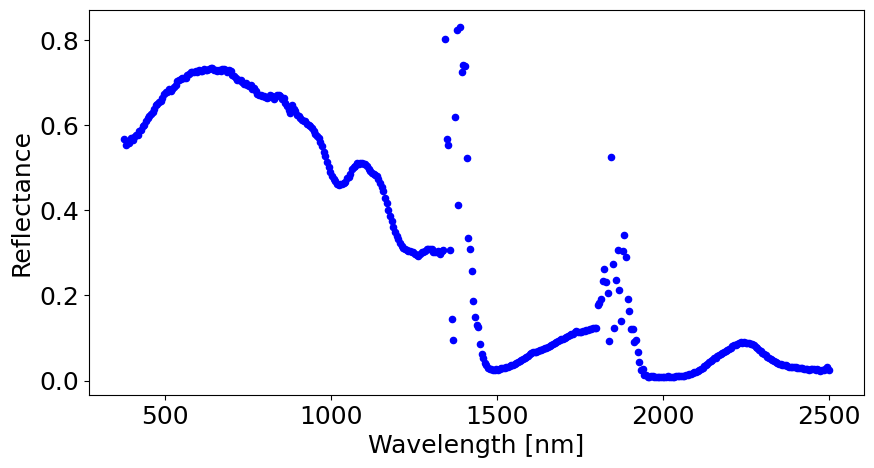

In [ ]:
# Visualize a single pixel's spectral signature
# Note: rasterio uses (bands, rows, cols) indexing, different from (rows, cols, bands)
i = 300  # row index
j = 900  # column index

# Extract pixel spectrum across all bands
pixel = rfl_array[:, i, j]

fig, ax = plt.subplots(1, 1, figsize=(10,5))
plt.rcParams.update({'font.size': 18})
ax.scatter(bands, pixel, color='blue', s=20)
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Reflectance')
ax.set_title(f'Spectral signature at pixel ({i}, {j})')
ax.grid(True, alpha=0.3)
plt.show()

## Working with Terrain Data

```{note}
Terrain and illumination data (*obs_ort files) for this flightline are not yet available in the S3 bucket. Once uploaded, they can be accessed the same way as the reflectance data shown above.

To obtain terrain data:
1. Visit https://search.earthdata.nasa.gov/
2. Search for "AVIRIS-NG L1B Calibrated Radiance, Facility Instrument Collection, V1"
3. Look for granules matching timestamp `ang20210429t191025` with `*obs_ort*` in the filename
4. The obs_ort files contain 11 bands with terrain and illumination information
```

### Terrain bands (when available):
- Band 1: Path length (m)
- Band 2: To sensor azimuth
- Band 3: To sensor zenith
- Band 4: To sun azimuth
- Band 5: To sun zenith
- Band 6: Solar phase
- Band 7: Slope
- Band 8: Aspect
- Band 9: cosine(i) (local solar illumination angle)
- Band 10: UTC Time
- Band 11: Earth-sun distance (AU)

**Important note:** Aspect follows convention from $-\pi$ to $\pi$.